## Library Installations

In [ ]:
#install libraries to allow big-query access
pip install --user --upgrade google-api-python-client
pip install --user pandas-gbq -U

In [53]:
import pandas as pd
import pandas_gbq
from google.cloud import bigquery
%load_ext google.cloud.bigquery
# Set default project here
pandas_gbq.context.project = 'bigquery-public-data'
pandas_gbq.context.dialect = 'standard'

In [68]:
%%bigquery
#Query top 5 rows to
SELECT *
FROM 
bigquery-public-data.fec.indiv20
limit 5


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/2 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|████████████████████████████████████████████████████| 2/2 [00:00<00:00, 676.77query/s]

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.91rows/s]


,cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,...,employer,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id
0,C00100404,A,M5,P,201909049163142120,15,IND,"MANSFIELD, JANET",NORFOLK,NE,...,USPS,POSTMASTER,2019-04-30,50.0,None,PR465206821292,1350631,None,P/R DEDUCTION ($50.00 BI-WEEKLY),4090520191672282142
1,C00100404,A,M5,P,201909049163142121,15,IND,"CLAWSON, G J. MS.",IDAHO FALLS,ID,...,US POSTAL SERVICE,POSTMASTER RETIRED,2019-04-30,83.0,None,PR54091421292,1350631,None,P/R DEDUCTION ($83.34 MONTHLY),4090520191672282146
2,C00100404,A,M5,P,201909049163142122,15,IND,"LINKO, SUSAN L.",BRECKENRIDGE,WY,...,US POSTAL SERVICE,POSTMASTER,2019-04-30,30.0,None,PR55208421292,1350631,None,P/R DEDUCTION ($30.00 BI-WEEKLY),4090520191672282152
3,C00100404,A,M6,P,201909049163142162,15,IND,"MANSFIELD, JANET",NORFOLK,NE,...,USPS,POSTMASTER,2019-05-31,150.0,None,PR465206821394,1350632,None,P/R DEDUCTION ($50.00 BI-WEEKLY),4090520191672282342
4,C00100404,A,M6,P,201909049163142163,15,IND,"CLAWSON, G J. MS.",IDAHO FALLS,ID,...,US POSTAL SERVICE,POSTMASTER RETIRED,2019-05-31,83.0,None,PR54091421394,1350632,None,P/R DEDUCTION ($83.34 MONTHLY),4090520191672282348


## Data Governance

1. Looking at the schema for the tables containing individual contributions (eg,
indiv20 ), what are some ways that we can uniquely identify individuals? What
transformations on the data should we consider making in order to accurately group
and associate transactions to individuals? What are the possible edge cases and
pitfalls to the grouping mechanisms that you recommend?

In [72]:
#description of columns in pandas dataframe. 
#More detailed description at https://www.fec.gov/campaign-finance-data/contributions-individuals-file-description/
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195482945 entries, 0 to 195482944
Data columns (total 21 columns):
 #   Column           Dtype  
---  ------           -----  
 0   cmte_id          object 
 1   amndt_ind        object 
 2   rpt_tp           object 
 3   transaction_pgi  object 
 4   image_num        int64  
 5   transaction_tp   object 
 6   entity_tp        object 
 7   name             object 
 8   city             object 
 9   state            object 
 10  zip_code         object 
 11  employer         object 
 12  occupation       object 
 13  transaction_dt   object 
 14  transaction_amt  float64
 15  other_id         object 
 16  tran_id          object 
 17  file_num         int64  
 18  memo_cd          object 
 19  memo_text        object 
 20  sub_id           int64  
dtypes: float64(1), int64(3), object(17)
memory usage: 30.6+ GB


This dataset tracks contributions by individuals of greater than $200 value. To begin to uniquely identify individuals, non-individual contributors should should be excluded. This dataset contains contributions from political parties, committees, PACs, and other groups as well as individuals. In addition, certain transactions are aggregations, amendments, refunds, memos, or percentages. These include. 

a. Per documentation, for the 'entity_tp' field, only value IND indicates an individual. 

b. The 'other_id' field has a NULL value for individuals.

c. In the 'transaction_tp' field certain values are refunds and will be excluded. These values include '17R', '17Y', '17U', '17Z', '20Y', '21Y', '22R','22Y','22Z','23Y','28L', '40T', '40Y', '40Z', '41T', '41Y','41Z', '42T', '42Y', '42Z'. 

d. Election law classifies certains groups as individuals for contribution purposes such as Native American Tribes. Because these are not 'individuals' as commonly understood, they will be excluded. These include field values '11', '24T', '24I'

e. Finally, the amndt_ind field has three values, N for new contributions, A for amendements, and T for terminations. Of these, only N should be included

Any dataset of individual contributors should have these constraints. 

In [143]:
%%bigquery
# query to show percent of total contributions from individual contributors.
SELECT transaction_tp, count(transaction_tp) donations, sum(transaction_amt) amt, sum(transaction_amt) * 100 / t.s AS perc
FROM bigquery-public-data.fec.indiv20
CROSS JOIN (SELECT sum(transaction_amt) AS s FROM bigquery-public-data.fec.indiv20) t
WHERE other_id IS NULL
AND entity_tp = 'IND'
AND transaction_tp IN ('10', '15', '15E', '15I','15T','16G','16J','30','31', '32')
AND amndt_ind = 'N'
GROUP BY transaction_tp, t.s
ORDER by perc DESC


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/5 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 1251.73query/s]

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.80rows/s]


,transaction_tp,donations,amt,perc
0,15,22805747,4.525579e+09,13.264257
1,10,1416686,2.869104e+09,8.409209
2,31,7718,5.265801e+07,0.154338
3,15E,374142,4.333497e+07,0.127013
4,32,2502,3.956456e+07,0.115962
5,30,264,1.233050e+07,0.036140


As shown from the query above, only about 22% of unique campaign contributions come from individuals, and the vast majority of these are made directly to the political actions committees associated with a candidate (Values 10, and 15). The remainder are specialized donations, such as convention floor donations, or donations made from smaller groups. 

To identify specific individuals, a primary key can be built from these records.

Individual names are listed, but need to be combined with other fields because mutiple individuals can have the same name. Of course using name field will not control for individuals listing their names in different ways across differing donations, or account for name changes. A simple count of names with the constraints listed above shows approximately 1.8M distinct names.

In [112]:
%%bigquery
# count distinct names with constraints developed above
SELECT COUNT (Distinct name) names
FROM bigquery-public-data.fec.indiv20
CROSS JOIN (SELECT sum(transaction_amt) AS s FROM bigquery-public-data.fec.indiv20) t
WHERE other_id IS NULL
AND entity_tp = 'IND'
AND transaction_tp IN ('10', '15', '15E', '15I','15T','16G','16J','30','31', '32')
AND amndt_ind = 'N'


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/4 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 1001.98query/s]

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/rows]


,names
0,1848161


One way to control for multiple individuals with the same name is to combine with other fields. The zip_code field is the most granular address field. An edge case here is that this would not account for if an individual moved to a different zip code in the year. Still, we should have a more accurate count. A count of name+zip shows approximately 2.3M contributors. 

In [128]:
%%bigquery
SELECT COUNT(DISTINCT (CONCAT (name,zip_code)))
FROM bigquery-public-data.fec.indiv20 
WHERE other_id IS NULL
AND entity_tp = 'IND'
AND transaction_tp IN ('10', '15', '15E', '15I','15T','16G','16J','30','31', '32')
AND amndt_ind = 'N'


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/3 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 751.80query/s]

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/rows]


,f0_
0,2298381


The final piece of demographic data are the employer and occupation fields. We can further concat our primary key with these fields. Cases not covered here would be if an individual changes either occupation or employer during the contribution cycle.
A distinct count here shows 2.4M contributors. The increase provided by employment data is only .1M, as opposed to .5M for the previous addition of zip code data. This is a good indication, from the 'hockey stick' or elbow method that the additional amount to be gained from each addition is slowing and additional gains may not be very great.

In [130]:
%%bigquery
SELECT COUNT(DISTINCT (CONCAT (name,zip_code,employer,occupation))) contributors
FROM bigquery-public-data.fec.indiv20 
WHERE other_id IS NULL
AND entity_tp = 'IND'
AND transaction_tp IN ('10', '15', '15E', '15I','15T','16G','16J','30','31', '32')
AND amndt_ind = 'N'


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/6 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|███████████████████████████████████████████████████| 6/6 [00:00<00:00, 1500.47query/s]

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/rows]


,contribtors
0,2423153


There is an edge case where two cities can be served by the same zip code. This only indicates they have the same post office. We can further concatenate state and city.

In [365]:
%%bigquery
SELECT COUNT(DISTINCT (CONCAT (name,state,city, zip_code,employer,occupation))) contributors
FROM bigquery-public-data.fec.indiv20 
WHERE other_id IS NULL
AND entity_tp = 'IND'
AND transaction_tp IN ('10', '15', '15E', '15I','15T','16G','16J','30','31', '32')
AND amndt_ind = 'N'


Query complete after 0.00s: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.89query/s]

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/rows]


,contributors
0,2432152


As expected there is a very small increase of about 9,000 individuals. At this level of granularity however, I would be concerned about overfitting. That is, if there are anomalies in any of the demographic fields such as incorrectly coded State, city, or any nulls, this may give a false impression of a higher number of individual contributors. It is perhaps impractical to fully investigate the anomalies of all datasets, and so we will use the slightly higher level of aggregation of name, zip, and employment information.

In summary, to identify unique contributors combine name, location, and employment info, along with field value constraints indicating the contributor is an individual. The methods outlined would result in over-counting if the individual changed names, address, or employment.

2. What is the purpose of the column amndt_ind and how can you use this column to
help deduplicate donation transaction records? Please provide an example of using
this column to deduplicate transactions for a single contributor.



According to the FEC Contributions by individuals file description page (https://www.fec.gov/campaign-finance-data/contributions-individuals-file-description/) the 'amndt_ind' column, the amendment indicator indicates 'if the report being filed is new (N), an amendment (A) to a previous report or a termination (T) report.' This column can be used to dedup transactions for a contributor because we know only new contributions will count as a record to include in totals. Examples in cells below.

In [54]:
%%bigquery
#distinct report types
select distinct amndt_ind from
bigquery-public-data.fec.indiv20


Query complete after 0.00s: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.33query/s]

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72rows/s]


,amndt_ind
0,T
1,A
2,N


In [58]:
%%bigquery
#total reports
SELECT 
COUNT(amndt_ind)
FROM 
bigquery-public-data.fec.indiv20


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/2 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|████████████████████████████████████████████████████| 2/2 [00:00<00:00, 667.03query/s]

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/rows]


,f0_
0,195482945


From this query, it appears there are 19,5482,945 individual contributions

In [61]:
%%bigquery
#contributions by type
SELECT amndt_ind report_type, count(amndt_ind) contributions
FROM 
bigquery-public-data.fec.indiv20
GROUP BY amndt_ind
ORDER BY contributions DESC


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/3 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|███████████████████████████████████████████████████| 3/3 [00:00<00:00, 1003.18query/s]

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.79rows/s]


,report_type,contributions
0,N,130552308
1,A,64909512
2,T,21125


However, by looking at the amnt_ind column, we can see there are actually 130,552,308 contributions. We can then get a true count with the following query:

Let's now depuplicate an individual contributor

In [361]:
%%bigquery
#Query to find high volume contributors
SELECT (CONCAT (name,zip_code,employer,occupation)) contributor, COUNT(*) count, sum(transaction_amt) contributions
FROM bigquery-public-data.fec.indiv20 
WHERE other_id IS NULL
AND entity_tp = 'IND'
AND transaction_tp IN ('10', '15', '15E', '15I','15T','16G','16J','30','31', '32')
GROUP BY contributor
ORDER BY count DESC
LIMIT 20


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/7 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|███████████████████████████████████████████████████| 7/7 [00:00<00:00, 1750.34query/s]

Downloading: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.22rows/s]


,contributor,count,contributions
0,None,1669132,538878789.0
1,"FIELDER, BETTY02813NOT EMPLOYEDNOT EMPLOYED",14859,14724.0
2,"DAVENPORT, BONNIE94608NONENONE",13608,5428.0
3,"HARRISON, ANN MARIE78731RETIREDRETIRED",9794,6624.0
4,"FORSYTHE, LYNN75052MS.TPF PROGRAMMER",9311,9018.0
5,"MASON, GWYNETH73132NOT EMPLOYEDNOT EMPLOYED",9258,11791.0
6,"IMMASCHE, SONIA80524NONENONE",7956,2868.0
7,"ROSENTHAL, WARNER60035NOT EMPLOYEDNOT EMPLOYED",7432,11018.0
8,"SIMONTON, GAIL22304NOT EMPLOYEDNOT EMPLOYED",7060,5003.0
9,"DONALDSON, PATRICIA14534XEROXENGINEER",6764,44.0


Somewhat improbably, Betty Fielder has made almost 15K contributions in the 2020 filing totalling nearly $15K. Let's restrict the count based on the amndt_ind field.

In [362]:
%%bigquery
#Query to find high volume contributors
SELECT (CONCAT (name,zip_code,employer,occupation)) contributor, COUNT(*) count, sum(transaction_amt) contributions
FROM bigquery-public-data.fec.indiv20 
WHERE other_id IS NULL
AND entity_tp = 'IND'
#amendment indicator
AND amndt_ind = 'N'
AND transaction_tp IN ('10', '15', '15E', '15I','15T','16G','16J','30','31', '32')
GROUP BY contributor
ORDER BY count DESC
LIMIT 20


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/5 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 1680.14query/s]

Downloading: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.72rows/s]


,contributor,count,contributions
0,None,1097609,324320247.0
1,"DAVENPORT, BONNIE94608NONENONE",12812,5140.0
2,"FIELDER, BETTY02813NOT EMPLOYEDNOT EMPLOYED",10133,8662.0
3,"HARRISON, ANN MARIE78731RETIREDRETIRED",8292,6210.0
4,"FORSYTHE, LYNN75052MS.TPF PROGRAMMER",7535,7296.0
5,"MASON, GWYNETH73132NOT EMPLOYEDNOT EMPLOYED",6952,9309.0
6,"IMMASCHE, SONIA80524NONENONE",6348,1942.0
7,"BUDGE, CLAUDIA94920NONENONE",5864,2634.0
8,"SIMONTON, GAIL22304NOT EMPLOYEDNOT EMPLOYED",5679,4407.0
9,"RIGGS, GARLAND20706NONENONE",5532,906.0


Now Betty Fielder's contributions have been depuplicated and we can see the total number of contributions has been reduced to 10,000 or by approximately 1/3. Her 'New' contributions total about $8,600.

3. For the calendar year 2020, what were the names of the top 20 committees
receiving contributions and how much did they receive? 

To answer this question, we will need to link to the committee tables. For this particular query, we will use cm20, which has the following schema.

In [161]:
%%bigquery
SELECT *
FROM bigquery-public-data.fec.cm20
limit 5


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Output and status COMPLETE : 0.00s:   0%|                          | 0/1 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41query/s]

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44rows/s]


,cmte_id,cmte_nm,tres_nm,cmte_st1,cmte_st2,cmte_city,cmte_st,cmte_zip,cmte_dsgn,cmte_tp,cmte_pty_affiliation,cmte_filing_freq,org_tp,connected_org_nm,cand_id
0,C00669044,None,None,None,None,None,None,None,None,None,None,A,None,None,None
1,C00677690,None,None,None,None,None,None,None,None,None,None,A,None,None,H8PA13158
2,C00690214,FREEDOM FOR ALL 777,GABRIEL ANGEL VARGAS JACKSON,None,None,None,None,None,None,None,None,T,None,None,None
3,C00703348,ARIZONA FOR AMERICA,"KOCH, THEODORE V",PO BOX 331,None,ALEXANDRIA,VA,22313,U,None,None,A,None,None,None
4,C00754986,THE COMMITTEE TO ELECT ROBERT D MCGEE FOR PRES...,ALLISON NELMS,378 WILLIS POPE RD,None,ANGIER,NC,27501,None,None,None,Q,None,None,P60015591


Now we can join the indiv20 table to the cm20 table to get names of committees receiving. Committee markers also need to be identified. We are only interested in contributions TO a committee. Contributions may come from any source. Contributions to committee are tracked in the transaction_tp field
Allowable transaction types are:
'10','15','15E','24K'
These types are all coded as TO a committee. If we don't add this restriction, we could include refunds, loans, percentages, etc.

Below are the top 20 committees receiving contributions.

In [171]:
%%bigquery
SELECT
  cmte_nm AS Committees,
  ROUND(SUM(transaction_amt)/1000000,2) Donations_in_millions
  FROM
    bigquery-public-data.fec.indiv20 indiv
JOIN
  bigquery-public-data.fec.cm20 cmte
ON
  cmte.cmte_id=indiv.cmte_id
WHERE transaction_tp IN ('10','15','15E','24K')
GROUP BY
  cmte_nm
ORDER BY
  2 desc
LIMIT
  20


Query complete after 0.00s: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 488.90query/s]

Downloading: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.32rows/s]


,Committees,Donations_in_millions
0,WINRED,3231.58
1,BIDEN FOR PRESIDENT,1084.80
2,BIDEN VICTORY FUND,1000.84
3,SENATE LEADERSHIP FUND,846.23
4,TRUMP VICTORY,788.47
5,TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE,713.59
6,HOUSE FREEDOM FUND,625.99
7,"DONALD J. TRUMP FOR PRESIDENT, INC.",531.62
8,SMP,511.93
9,REPUBLICAN NATIONAL COMMITTEE,467.47


Who were the top 20 individuals making contributions and how much did they contribute? To answer this, we can reuse a portion of our code from question 1, where we have identified individual contributors. 

In [190]:
%%bigquery
# query to show top individual contributors
SELECT name, ROUND(sum(transaction_amt)/1000000,2) donations_in_millions
FROM bigquery-public-data.fec.indiv20
WHERE other_id IS NULL
AND entity_tp = 'IND'
AND transaction_tp IN ('10', '15', '15E', '15I','15T','16G','16J','30','31', '32')
#We can remove the amndt_ind = 'N' restriction because we do not need to worry about depuding individuals. 
#We are only summing results.
#AND amndt_ind = 'N'
GROUP BY name
ORDER by 2 DESC
LIMIT 20


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/4 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 1002.64query/s]

Downloading: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.51rows/s]


,name,donations_in_millions
0,"BLOOMBERG, MICHAEL R.",309.54
1,"ADELSON, MIRIAM",220.57
2,"ADELSON, SHELDON",150.84
3,"MELLON, TIMOTHY",150.08
4,"STEYER, THOMAS F.",128.21
5,"MOSKOVITZ, DUSTIN A",118.78
6,"SCHWARZMAN, STEPHEN A.",105.13
7,"GRIFFIN, KENNETH C.",103.54
8,"ADELSON, SHELDON G.",71.54
9,"UIHLEIN, RICHARD",69.25


How many committees are both recipients and contributors?

To solve this query, we need to join the indiv20 table to the cm20 table and count where indiv.name = cmte.cmte_nm. We will include transaction_tp restrictions from previous queries.

In [174]:
%%bigquery
SELECT
  COUNT(DISTINCT cmte_nm) matches
  FROM
    bigquery-public-data.fec.indiv20 indiv
JOIN
  bigquery-public-data.fec.cm20 cmte
ON
  cmte.cmte_id=indiv.cmte_id
WHERE transaction_tp IN ('10', '15', '15E', '15I','15T','16G','16J','24K','30','31', '32')


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/4 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 1004.62query/s]

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/rows]


,matches
0,8515


4. Is there any relationship between geo-demographic variables (e. g. state, city) and
donation?

Our dataset has the following geographic variables: city and state. Let's first look at state. We should also restrict transactions to remove loans, refunds, and other non-contribution transactions. Here I've included any transaction type coded 'contribution'

In [236]:
%%bigquery
SELECT
  state, sum(transaction_amt)/1000000 donations_in_millions
  FROM
    bigquery-public-data.fec.indiv20 indiv
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
group by state
order by 2 Desc
Limit 20


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/3 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 996.27query/s]

Downloading: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.57rows/s]


,state,donations_in_millions
0,CA,5084.189919
1,NY,2977.121082
2,DC,2148.293558
3,VA,2146.335832
4,TX,2042.003664
5,FL,1888.105074
6,IL,1284.004142
7,MA,1043.354716
8,NV,815.725007
9,WA,794.302576


There are a few data issues left unanswered with this nalysis. This represents total contributions and the states do not have equal numberes of donors. Next, the state is not a very granular level of data. Still, let's see if a visualization helps. 

In [237]:
# Download query results.
bqclient = bigquery.Client()

query_string = """
SELECT
  state, sum(transaction_amt)/1000000 donations_in_millions
  FROM
    bigquery-public-data.fec.indiv20 indiv
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
group by state
order by 2 Desc
Limit 20
"""

state_limit = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(
        create_bqstorage_client=True,
    )
)
print(state_limit.head())

  state  donations_in_millions
0    CA            5084.189919
1    NY            2977.121082
2    DC            2148.293558
3    VA            2146.335832
4    TX            2042.003664


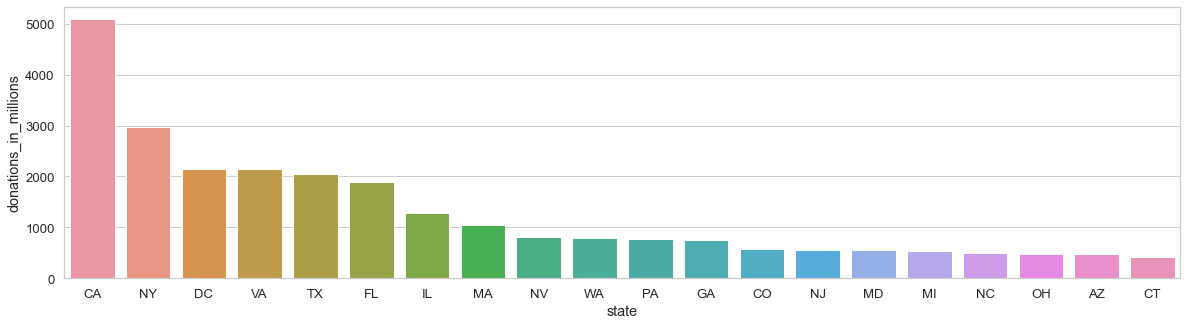

In [245]:
#import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
fig = plt.figure(figsize = (20,5))
ax = sns.barplot(x="state", y="donations_in_millions", data=state_limit)

Here it appears large states like CA, NY, VA, TX, FL, etc which are the most populous in the nation lead in donations, as well as the political hub of Washington DC. One conclusion we can draw is that population size appears to be positively correlated to donations. Let's examine the entire dataset of state data.

In [180]:
%%bigquery
SELECT DISTINCT state
  FROM
    bigquery-public-data.fec.indiv20 indiv


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/2 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|████████████████████████████████████████████████████| 2/2 [00:00<00:00, 673.62query/s]

Downloading: 100%|█████████████████████████████████████████████████████████████████| 108/108 [00:01<00:00, 58.86rows/s]


,state
0,NS
1,NU
2,SO
3,SH
4,SE
...,...
103,UT
104,NB
105,TO
106,HO


There are 108 different state codes! We should investigate the total contributions of these states by creating a grouping. We will create a grouping of all 50 states, plus Washington DC, and note everything else as "OUS" for Outside the US. 

In [240]:
%%bigquery
SELECT CASE WHEN state IN ('AL','AK','AZ','AR','CA','CO','CT','DE','DC','FL',
'GA','HI','ID','IL','IN','IA','KS','KY','LA','ME',
'MD','MA','MI','MN','MS','MO','MT','NE','NV','NH',
'NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI',
'SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY') THEN state ELSE 'OUS' END state, sum(transaction_amt)/1000000 donations_in_millions
  FROM
    bigquery-public-data.fec.indiv20 indiv
group by 1
order by 2 Desc


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/3 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|███████████████████████████████████████████████████| 3/3 [00:00<00:00, 1017.05query/s]

Downloading: 100%|███████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 31.11rows/s]


,state,donations_in_millions
0,CA,5813.538292
1,NY,5206.314339
2,DC,2175.876122
3,VA,2154.177614
4,TX,2094.292022
5,FL,1913.254965
6,IL,1303.189084
7,MA,1069.736056
8,GA,825.566536
9,NV,820.690083


We can see that overseas contributions, even aggregated, are only ranked 45th out of 52. We can probably disregard them in aggregate, though it may be worthwhile to dive deeper into the top contributing overseas locations.


Let's next look at city contributions. Because cities are not unique, we should create a combined column as 'city, state'. 

In [198]:
%%bigquery
SELECT COUNT (DISTINCT(CONCAT(city,", ",state))) unique_cities
  FROM
    bigquery-public-data.fec.indiv20 indiv
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/3 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|███████████████████████████████████████████████████| 3/3 [00:00<00:00, 1003.10query/s]

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/rows]


,unique_cities
0,79959


There are nearly 80,000 unique cities

In [243]:
%%bigquery
SELECT CONCAT(city,", ",state) city_state, sum(transaction_amt)/1000000 contributions_in_millions
  FROM
    bigquery-public-data.fec.indiv20 indiv
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
group by city_state
order by 2 Desc
LIMIT 20


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/3 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|███████████████████████████████████████████████████| 3/3 [00:00<00:00, 1002.94query/s]

Downloading: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.28rows/s]


,city_state,contributions_in_millions
0,"WASHINGTON, DC",2140.292100
1,"NEW YORK, NY",1919.932423
2,"ARLINGTON, VA",1187.129193
3,"SAN FRANCISCO, CA",826.020656
4,"LAS VEGAS, NV",687.547355
5,"CHICAGO, IL",613.822304
6,"LOS ANGELES, CA",466.519435
7,"HOUSTON, TX",373.748026
8,"DALLAS, TX",343.294350
9,"ATLANTA, GA",333.727056


Unsurprisingly, given its prominence both politically and in the state dataset above, Washington DC tops this list

Let's visualize this data by placing into a dataframe

In [246]:
# Download query results.

query_string = """
SELECT CONCAT(city,", ",state) city_state, sum(transaction_amt)/1000000 contributions_in_millions
  FROM
    bigquery-public-data.fec.indiv20 indiv
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
group by city_state
order by 2 Desc
LIMIT 20
"""

city_limit = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(
        create_bqstorage_client=True,
    )
)
print(city_limit.head())

          city_state  contributions_in_millions
0     WASHINGTON, DC                2140.292100
1       NEW YORK, NY                1919.932423
2      ARLINGTON, VA                1187.129193
3  SAN FRANCISCO, CA                 826.020656
4      LAS VEGAS, NV                 687.547355


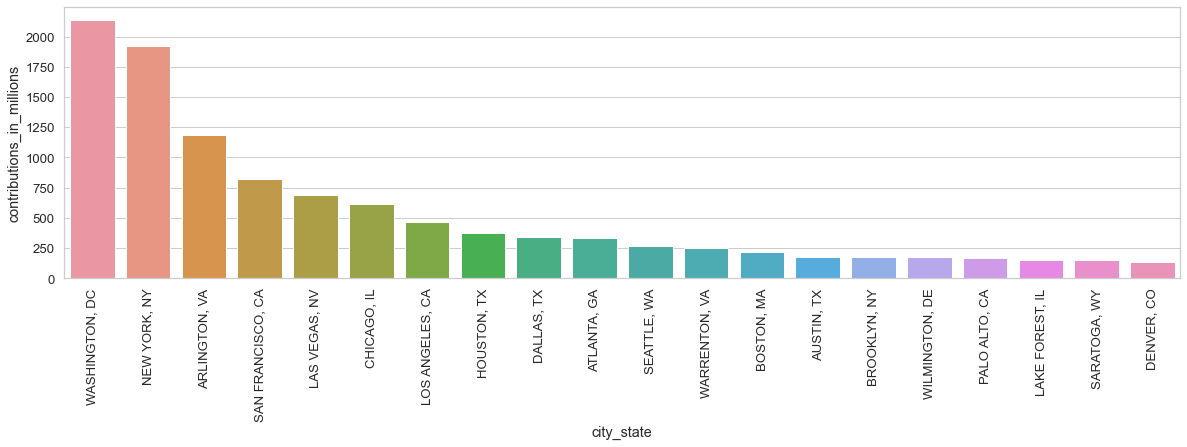

In [250]:
fig = plt.figure(figsize = (20,5))
ax = sns.barplot(x="city_state", y="contributions_in_millions", data=city_limit)
ax.tick_params(axis='x', rotation=90)

Next, let's quickly look at average contribution size for both state and city, state data

In [259]:
%%bigquery
SELECT CASE WHEN state IN ('AL','AK','AZ','AR','CA','CO','CT','DE','DC','FL',
'GA','HI','ID','IL','IN','IA','KS','KY','LA','ME',
'MD','MA','MI','MN','MS','MO','MT','NE','NV','NH',
'NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI',
'SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY') THEN state ELSE 'OUS' END state, sum(transaction_amt)/count(*) ave_contributions
  FROM
    bigquery-public-data.fec.indiv20 indiv
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
group by state
order by 2 DESC
limit 20


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/3 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|███████████████████████████████████████████████████| 3/3 [00:00<00:00, 1008.00query/s]

Downloading: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.38rows/s]


,state,ave_contributions
0,DC,1187.655137
1,WY,747.411595
2,NV,413.264700
3,VA,343.846980
4,DE,293.379549
5,NY,228.797289
6,IL,196.239360
7,OUS,189.446773
8,MA,177.184451
9,CT,165.350055


A very different picture emerges from the total contribution by state. Large states such as CA, FL, and TX are no longer at the top, though they are still mostly in the list. Again, overseas locations emerge as a potential source of high dollar, low-volume donations.

In [253]:
%%bigquery
SELECT CONCAT(city,", ",state), sum(transaction_amt)/count(*)/1000 ave_cont_thousands
  FROM
    bigquery-public-data.fec.indiv20 indiv
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
group by CONCAT(city,", ",state)
order by 2 DESC
limit 20


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/3 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 750.37query/s]

Downloading: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.09rows/s]


,f0_,ave_cont_thousands
0,"LITTLE JACKSON HOLE, WY",1102.533333
1,"SOUTH NAPLES, FL",1000.000000
2,"BALA CYNWYND, PA",871.542857
3,"UNITEMIZED, DC",825.156000
4,"WILIMINGTON, NC",571.479429
5,"LITTLE JACKSON HOL, WY",505.700000
6,"RELEIGH, NC",504.166667
7,"FRIDAY HARBOR, WI",500.000000
8,"ALM BEACH, FL",250.000000
9,"TA, ZZ",249.980000


A few things become clear from this approach. First, the town of Little Jackson Hole, WY tops the list. A quick google search shows this is a small town with a population of aroud 36,000 in 2020. Clearly a few high dollar donations are skewing the average. Also, some overseas locations are listed. Like the Little Jackson Hole example, these are probably skewed by a small number of high dollar donations. We should investigate.

In [366]:
%%bigquery
#query to look at individual contributions from Little Jackson Hole
SELECT CONCAT(city,", ",state) city_state, transaction_amt
  FROM
    bigquery-public-data.fec.indiv20 indiv
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
AND city = 'LITTLE JACKSON HOLE'
order by 2 DESC


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/2 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.31query/s]

Downloading: 100%|███████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 10.74rows/s]


,city_state,transaction_amt
0,"LITTLE JACKSON HOLE, WY",3750000.0
1,"LITTLE JACKSON HOLE, WY",3750000.0
2,"LITTLE JACKSON HOLE, WY",3190000.0
3,"LITTLE JACKSON HOLE, WY",3190000.0
4,"LITTLE JACKSON HOLE, WY",2000000.0
5,"LITTLE JACKSON HOLE, WY",2000000.0
6,"LITTLE JACKSON HOLE, WY",530000.0
7,"LITTLE JACKSON HOLE, WY",530000.0
8,"LITTLE JACKSON HOLE, WY",240000.0
9,"LITTLE JACKSON HOLE, WY",240000.0


Our suspicion was confirmed as there are a number of multi-million dollar donations

Now we have several different methods of looking at the donation data: Total by state, average by state, total and average by city + state. Note that in a fuller analysis, we could pull in population data for 2020 and calculate contribution by resident, but that is outside the scope of this problem.

5. What's the calendar effect and role of seasonality (if any) in donation activity? Does
the seasonality change at all in off year election cycles?

To answer this question, we will need to combine several years of individual contributor data. Looking at the 'indiv' datasets, it appears data is reported only in even years. To get a sense of seasonality, let's look at data from 2000-2020 which we can do with the UNION DISTINCT function.

In [367]:
%%bigquery
SELECT DISTINCT EXTRACT(year FROM transaction_dt) year, COUNT(*) transactions, SUM(transaction_amt) contributions
FROM (
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv00
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv02
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv04
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv06
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv08
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv10
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv12
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv14
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv16
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv18
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv20
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
)
GROUP BY year
ORDER BY year


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/5 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 1249.94query/s]

Downloading: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 35.23rows/s]


,year,transactions,contributions
0,NaN,1023,3.206954e+06
1,1015.0,3,3.900000e+03
2,1216.0,1,2.500000e+01
3,1916.0,1,1.000000e+03
4,1930.0,1,2.000000e+01
5,1931.0,1,1.000000e+03
6,1969.0,1,5.000000e+02
7,1979.0,2,1.250000e+03
8,1980.0,1,5.000000e+02
9,1988.0,1,8.250000e+02


Clearly there are some data anomalies here, but judging by count and sum of transactions during the non-standard years, except for null years, these are of such small scale, generally only a few per 'year', and only a few thousand dollars, compared to billions of dollars in correctly formatted years, we can ignore for now. Although, for data hygiene we should note and investigate further by gathering counts by report, etc. Additional options include hard-coding the year according to the filing year, but with multiple datasets this could end up being resource intensive and does not expose errors in data.

We will then restrict the years to only 2000 - 2020

In [342]:
%%bigquery
SELECT EXTRACT(year FROM transaction_dt) year, EXTRACT(month FROM transaction_dt) month, 
SUM(transaction_amt)/1000 monthly_amt_thousands
FROM (
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv00
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv02
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv04
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv06
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv08
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv10
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv12
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv14
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv16
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv18
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv20
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
)
WHERE EXTRACT(year FROM transaction_dt) BETWEEN 2000 and 2020
GROUP BY year, month
ORDER BY year, month


Query is running:   0%|                                                                       | 0/1 [00:00<?, ?query/s]
Query executing stage S00: Input and status COMPLETE : 0.00s:   0%|                           | 0/4 [00:00<?, ?query/s]
Query complete after 0.00s: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 1336.72query/s]

Downloading: 100%|████████████████████████████████████████████████████████████████| 252/252 [00:01<00:00, 173.19rows/s]


,year,month,monthly_amt_thousands
0,2000,1,5755.442
1,2000,2,8734.076
2,2000,3,15607.973
3,2000,4,13741.900
4,2000,5,16669.027
...,...,...,...
247,2020,8,254971.313
248,2020,9,526023.864
249,2020,10,686466.735
250,2020,11,153216.725


In [343]:
#Let's graph these lines to check for seasonality
query_string = """
SELECT EXTRACT(year FROM transaction_dt) year, EXTRACT(month FROM transaction_dt) month, 
SUM(transaction_amt)/1000 monthly_amt_thousands
FROM (
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv00
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv02
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv04
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv06
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv08
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv10
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv12
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv14
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv16
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv18
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv20
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
)
WHERE EXTRACT(year FROM transaction_dt) BETWEEN 2000 and 2020
AND EXTRACT (month FROM transaction_dt) BETWEEN 1 and 12
GROUP BY year, month
ORDER BY year, month
"""

monthly = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(
        create_bqstorage_client=True,
    )
)
print(monthly.head())


   year  month  monthly_amt_thousands
0  2000      1               5755.442
1  2000      2               8734.076
2  2000      3              15607.973
3  2000      4              13741.900
4  2000      5              16669.027


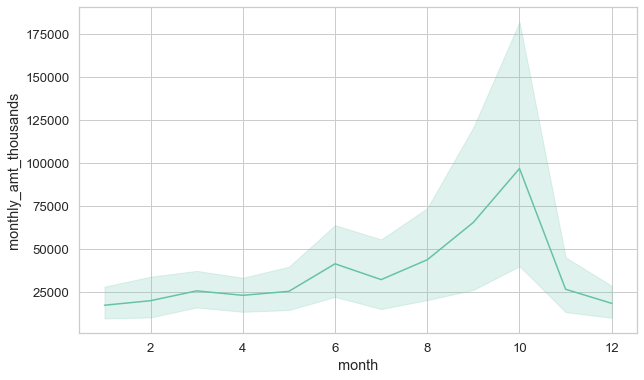

In [345]:
plt.figure(figsize=(10,6))
sns.lineplot(x='month', y='monthly_amt_thousands', data=monthly, markers=True, dashes=False)

The graph above contains total monthly contributions for years 2000-2020. The solid line represents the average monthly contribution and the lighter green represents the maximum and minimum contributions in that month. There are two major trends related to seasonality which are readily apparent. First, there is a large increase around month 10. Next, there is a smaller increase around month 6. This is most likely due to contributions related to the general election (month 10) and the primary (month 6). To test this, we can look at cycles in which there is and is not a presidential election. Our hypothesis is these trends will persist even in "off" (non-presidential) years, but will be much diminished.

In [349]:
#Let's graph these lines to check for seasonality
#adding a boolean column "Pres" to indicate if election occurs during a presidential (Y) or non presidential (N) election years
query_string = """
SELECT EXTRACT(year FROM transaction_dt) year, EXTRACT(month FROM transaction_dt) month,
CASE WHEN MOD(EXTRACT(year FROM transaction_dt),4) = 0 THEN 'Y' ELSE 'N' END Pres, SUM(transaction_amt)/1000 monthly_amt_thousands
FROM (
SELECT transaction_dt, transaction_amt 
FROM bigquery-public-data.fec.indiv00
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv02
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv04
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv06
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv08
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv10
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv12
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv14
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv16
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv18
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
UNION DISTINCT
SELECT transaction_dt, transaction_amt FROM bigquery-public-data.fec.indiv20
WHERE transaction_tp IN ('10','11', '15', '15E', '15I','15T','15Z','17R','18K','18L','22R','22Y','22Z','24K','24P',
                         '24T','24U','24Z')
)
WHERE EXTRACT(year FROM transaction_dt) BETWEEN 2000 and 2020
AND EXTRACT (month FROM transaction_dt) BETWEEN 1 and 12
GROUP BY year, month, pres
ORDER BY year, month
"""

pres = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(
        create_bqstorage_client=True,
    )
)
print(pres.head())


   year  month  Pres  monthly_amt_thousands
0  2000      1     1               5755.442
1  2000      2     1               8734.076
2  2000      3     1              15607.973
3  2000      4     1              13741.900
4  2000      5     1              16669.027


We can now plot these out and investigate any election year trends.

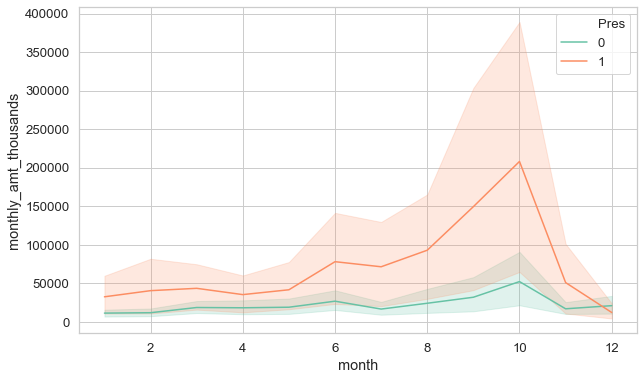

In [352]:
plt.figure(figsize=(10,6))
sns.lineplot(x='month', y='monthly_amt_thousands', hue = 'Pres', data=pres, markers=True, dashes=False)

The result is as expected - The peaks at months 10 and 6 persist in non-presidential election years, but are less pronounced. In non-presidential election years contributions nearly double from month 6 to month 10 and in presidential election years, contributions nearly triple between the same months. Of course, the overall trend here is that contributions are much higher in presidential election years than in non-presidential ones.